## Reproduce figures in the paper for the ATP surveys

In [1]:
base_dir = '../results/atp/'
dir_individual = base_dir + 'model_responses/'
census_dir = base_dir + 'human_responses/'

In [2]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('..')

In [3]:
from plot_utils.models import hf_models, model_names, instruct, model_sizes, openai_models

all_models = sorted(hf_models, key=lambda x: model_sizes[x])
base_models = sorted(list(set(all_models) - set(instruct.keys())), key=lambda x: model_sizes[x])
instruction_models = list(set(instruct.keys()) - set(openai_models))
instruction_models = sorted(instruction_models, key=lambda x: model_sizes[x])

# due to space constrains, do not plot gptneo2.7b and llama since similar models were evaluated
plot_models = list(set(base_models) - set(['gptneo2.7b', 'llama7b', 'llama13b', 'llama65b']))
plot_models = sorted(plot_models, key=lambda x: model_sizes[x])

### Load human responses

In [4]:
from scipy.stats import wasserstein_distance

def str2floats(s):
    vs = s[1:-1].split(' ')
    arr = np.array([float(v) for v in vs if len(v) > 1])
    return arr

def get_max_wd(ordered_ref_weights):
    d0, d1 = np.zeros(len(ordered_ref_weights)), np.zeros(len(ordered_ref_weights))
    d0[np.argmax(ordered_ref_weights)] = 1
    d1[np.argmin(ordered_ref_weights)] = 1
    max_wd = wasserstein_distance(ordered_ref_weights, ordered_ref_weights, d0, d1)
    return max_wd

In [5]:
PEW_SURVEY_LIST = [26, 27, 29, 32, 34, 36, 41, 42, 43, 45, 49, 50, 54, 82, 92] 

human_df = []
for wave in PEW_SURVEY_LIST:
    SURVEY_NAME = f'American_Trends_Panel_W{wave}'
    hdf = pd.read_csv(os.path.join(census_dir, f'{SURVEY_NAME}_human.csv'))
    human_df.append(hdf)
human_df = pd.concat(human_df)

variables = list(set(human_df.qkey.unique()))
census_responses = {}
for var in variables:
    s = human_df[(human_df.qkey == var) & (human_df.attribute == 'Overall')].D_H.iloc[0]   
    census_responses[var] = str2floats(s)
    
n_categories = {v: len(census_responses[v]) for v in variables}

### Load model responses

In [ ]:
from surveying_llms.load_responses import load_naive_responses, load_adjusted_responses

naive_responses = load_naive_responses(dir_individual, all_models, n_categories, openai_models)
choice_responses, adjusted_responses = load_adjusted_responses(dir_individual, all_models, variables)

# Process to the same number of answer choices as Santurkar, renormalize
adjusted_responses = {v: {m: adjusted_responses[v][m][:n_categories[v]] 
                          for m in all_models} for v in variables}
adjusted_responses = {v: {m: adjusted_responses[v][m] / adjusted_responses[v][m].sum()
                          for m in all_models} for v in variables}

In [ ]:
from plot_utils.plot_utils import compute_entropy, compute_kl

uniform_responses = {var: np.ones(n_categories[var]) / n_categories[var] for var in variables}
uniform_entropies = {var: compute_entropy(uniform_responses[var]) for var in variables}
census_norm_entropies = {v: compute_entropy(census_responses[v]) / uniform_entropies[v] for v in variables}
naive_norm_entropies = {v: {m: compute_entropy(naive_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}
adjusted_norm_entropies = {v: {m: compute_entropy(adjusted_responses[v][m]) / uniform_entropies[v] 
                            for m in all_models} for v in variables}

kl_uniform_census = {v: compute_kl(uniform_responses[v], census_responses[v]) for v in variables}
adjusted_kl_census = {v: {m: compute_kl(adjusted_responses[v][m], census_responses[v])
                   for m in all_models} for v in variables}
adjusted_kl_uniform = {v: {m: compute_kl(adjusted_responses[v][m], uniform_responses[v])
                   for m in all_models} for v in variables}

### Figure 2a

In [ ]:
from plot_utils.plot_utils import plot_a_bias

a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in base_models}

plot_a_bias(a_bias, plot_models, model_names, figsize=(6.7, 2), alpha=0.05)
plt.ylim([None, 0.77])
plt.show()

a_bias = {m: [abs(choice_responses[v][m][0] - (1. / n_categories[v])) for v in variables] for m in all_models}
plot_a_bias(a_bias, instruction_models, model_names, figsize=(6.7, 2), alpha=0.05)
plt.ylim([None, 0.77])
plt.show()

### Figure 4  and Figure 5a

In [ ]:
from plot_utils.plot_utils import plot_adjusted_entropy

plot_adjusted_entropy(naive_norm_entropies, census_norm_entropies, 
                      plot_models, variables, model_names, figsize=(7.1, 2), alpha=0.05)
plt.show()

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      plot_models, variables, model_names, figsize=(7.2, 1.5), ylegend=1.3, alpha=0.05)
plt.show()

plot_adjusted_entropy(adjusted_norm_entropies, census_norm_entropies, 
                      instruction_models, variables, model_names, figsize=(7, 1.5), ylegend=1.3, alpha=0.05)
plt.show()

In [ ]:
frac = {m: 0 for m in all_models}
for m in all_models:
    for v in variables:
        if adjusted_kl_uniform[v][m] >= adjusted_kl_census[v][m]:
            frac[m] += 1
frac = {k: v / len(variables) for k, v in frac.items()}
print('Largest fraction of questions closer to census than to uniform: %.2f' % (max(frac.values())))

### Alignment to different subgroups

In [11]:
df_groups = human_df.attribute + human_df.group

def get_state_responses(state):
    responses = {}
    state_data = human_df[df_groups == state]
    for var in variables:
        var_data = state_data[state_data.qkey == var]
        if len(var_data) > 0:
            var_data = var_data.D_H.iloc[0]
            responses[var] = str2floats(var_data)
    return responses

states = list(set(df_groups.unique()) - set(['OverallOverall']))

# Get the responses of every state
response_overall = get_state_responses('OverallOverall')
responses_states = {s: get_state_responses(s) for s in states}

In [ ]:
def alignment(p1, p2):
    d = [i+1 for i in range(p1.size)]
    return 1 - wasserstein_distance(d, d, p1, p2) / get_max_wd(d)

uniform_alignment = {m: np.mean([alignment(adjusted_responses[v][m], uniform_responses[v])
                                   for v in response_overall.keys()]) for m in all_models}
overall_alignmen = {m: np.mean([alignment(adjusted_responses[v][m], rv)
                                   for v, rv in response_overall.items()]) for m in all_models}

print('Computing alignment from models to subgroups...')
subgroup_alignment = {}
for m in tqdm(all_models):
    subgroup_alignment[m] = {s: np.mean([alignment(adjusted_responses[v][m], rs) 
                                 for v, rs in rs.items()]) for s, rs in responses_states.items()}

In [13]:
print('Computing alignment from models to subgroups...')
unad_subgroup_alignment = {}
for m in tqdm(all_models):
    unad_subgroup_alignment[m] = {s: np.mean([alignment(naive_responses[v][m], rs) 
                                 for v, rs in rs.items()]) for s, rs in responses_states.items()}

100%|██████████| 29/29 [02:13<00:00,  4.62s/it]


In [14]:
subgroup_ent = {c: [] for c in states}
for s, rs in responses_states.items():
    for v, rs in rs.items():
        u = np.ones(rs.size) / rs.size
        subgroup_ent[s].append(compute_entropy(rs) / compute_entropy(u))
subgroup_ent = {c: np.mean(subgroup_ent[c]) for c in states}

### Figure 6

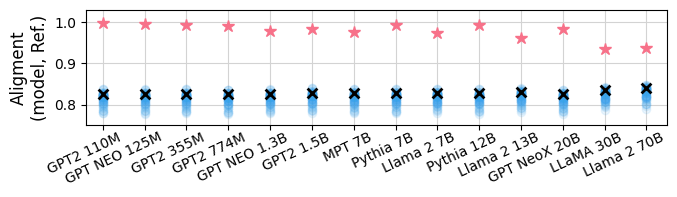

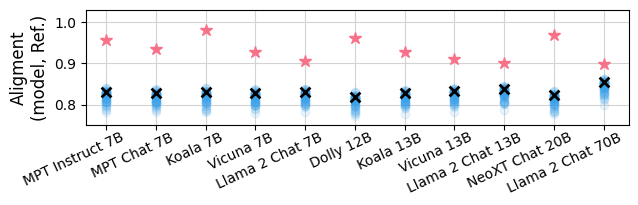

In [15]:
from plot_utils.plot_utils import plot_divergence_subgroups

plot_divergence_subgroups(subgroup_alignment, uniform_alignment, overall_alignmen, plot_models, model_names, 
                          figsize=(7.5, 1.5))
plt.ylim([0.75, 1.03])
plt.yticks([0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.show()

plot_divergence_subgroups(subgroup_alignment, uniform_alignment, overall_alignmen, instruction_models, model_names, 
                          figsize=(7, 1.5))
plt.ylim([0.75, 1.03])
plt.yticks([0.8, 0.9, 1.0])
plt.ylabel('Aligment\n(model, Ref.)')
plt.show()

### Figure 9a

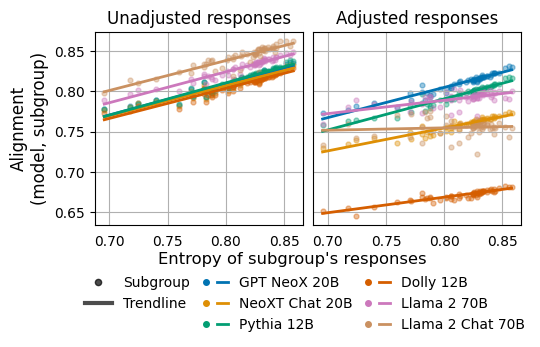

In [16]:
from plot_utils.plot_utils import plot_similarity_opinions

# plot the largest models
fewer_models = ['gptneox', 'gptneoxchat',
                'pythia12', 'dolly12b',
                'llama2-70b',
                'llama2-70b-chat']

plot_similarity_opinions(states, subgroup_alignment, unad_subgroup_alignment, 
                         subgroup_ent, fewer_models, model_names,
                             xlabel='Entropy of subgroup\'s responses', 
                             ylabel='Alignment\n(model, subgroup)',
                             title1='Unadjusted responses', title2='Adjusted responses')
plt.savefig('../plots/lin-trend-atp.pdf', bbox_inches='tight')

In [17]:
llama2chat_atp = {
    'entropies': subgroup_ent,
    'chat-unadjusted': unad_subgroup_alignment['llama2-70b-chat'],
    'chat-adjusted': subgroup_alignment['llama2-70b-chat'],
    'base-unadjusted': unad_subgroup_alignment['llama2-70b'],
    'base-adjusted': subgroup_alignment['llama2-70b'],
}

import json
with open('../results/gaswvs/llama2-chat-gas.json', 'r') as f:
    llama2chat_gas = json.load(f)

In [18]:
import seaborn as sb

def make_plot2(divergence_unadj, divergence, subgroup_ents1, subgroup_ents2):
    fig, axs = plt.subplots(1, 2, figsize=(6., 2.5))

    ax = axs[0]
    colors = sb.color_palette("colorblind")

    xaxis = list([v for v in subgroup_ents1.values()])
    x_range = [min(xaxis), max(xaxis)]
    for i, (m, p) in enumerate(divergence_unadj.items()):
        yaxis = [p[s] for s in subgroup_ents1.keys()]
        ax.plot(xaxis, yaxis, '.', c=colors[i], markersize=7, alpha=0.4, zorder=-10)
        f = np.poly1d(np.polyfit(xaxis, yaxis, 1))
        ax.plot(x_range, f(x_range), '', c=colors[i], linewidth=2.)

    ax.set_ylabel('Alignment\n(model, subgroup)', fontsize=12)
    ax.set_title('ATP')
    ax.xaxis.set_ticks_position('none')
    ax.grid()

    ax = axs[1]

    xaxis = list([v for v in subgroup_ents2.values()])
    x_range = [min(xaxis), max(xaxis)]
    for i, (m, p) in enumerate(divergence.items()):
        yaxis = [p[s] for s in subgroup_ents2.keys()]
        ax.plot(xaxis, yaxis, '.', c=colors[i], markersize=7, alpha=0.4, zorder=-10)
        f = np.poly1d(np.polyfit(xaxis, yaxis, 1))
        ax.plot(x_range, f(x_range), '', c=colors[i], linewidth=2.)
        
    # Legend
    legend_elements = []


    labels_= []

    legend_elements.append(plt.Line2D([0], [0], color='k', marker='.',
                                      markersize=9, alpha=0.7,
                                      markerfacecolor='k', lw=0))
    labels_.append('Subgroup')
    legend_elements.append(plt.Line2D([0], [0], color='k', alpha=0.7,
                                      markersize=11,
                                      markerfacecolor='k', lw=3))
    labels_.append('Trendline')
    legend_elements.append(plt.Line2D([0], [0], color='w', alpha=0.7,
                                      markersize=11,
                                      markerfacecolor='w', lw=3))
    labels_.append('')

    # lines with the names
    for c, m in zip(colors, divergence_unadj.keys()):
        # dots
        dot = plt.Line2D([0], [0], color=c, marker='.',
                         label='', markersize=8,
                         markerfacecolor=c, lw=0)

        # line 
        line = plt.Line2D([0], [0], color=c, 
                          markersize=11, markerfacecolor=c, lw=2)

        legend_elements.append((dot, line))
        labels_.append(m)
        
    legend_labels = [(line, line), (line, line)]
    from matplotlib.legend_handler import HandlerTuple, HandlerLine2D
    legend = ax.legend(legend_labels, ['Combined Data 1', 'Combined Data 2'], handler_map={tuple: HandlerTuple(ndivide=None)})

    legend_position = (0.7, -.2)  # Coordinates (x, y) for top left position
    ax.legend(legend_elements, labels_, loc='upper right',
              bbox_to_anchor=legend_position, frameon=False, ncols=2, handletextpad=.8, columnspacing=0.7,
              handler_map={tuple: HandlerTuple(ndivide=None), 
                           type(line): HandlerLine2D()})

    ax.set_xlabel('Entropy of subgroup\'s responses', fontsize=11.8)
    ax.set_title('GAS/WVS')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_label_coords(-0.1, -.14)
    ax.grid()

    plt.subplots_adjust(wspace=0.3)

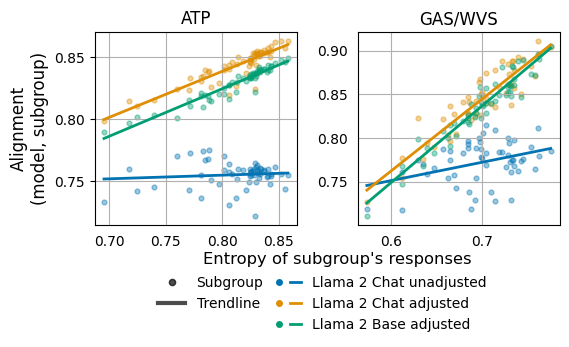

In [19]:
d1 = {'Llama 2 ' + k.replace('-', ' ').capitalize(): llama2chat_atp[k] for k in ['base-adjusted']}
d1.update({'Llama 2 ' + k.replace('-', ' ').capitalize(): llama2chat_atp[k] for k in ['chat-unadjusted', 
                                                                                      'chat-adjusted']})

d2 = {'Llama 2 ' + k.replace('-', ' ').capitalize(): llama2chat_gas[k] for k in ['base-adjusted']}
d2.update({'Llama 2 ' + k.replace('-', ' ').capitalize(): llama2chat_gas[k] for k in ['chat-unadjusted',
                                                                                      'chat-adjusted']})

models = ['chat-unadjusted', 'chat-adjusted', 'base-adjusted']
models = ['Llama 2 ' + m.replace('-', ' ').capitalize() for m in models]
d1 = {m: d1[m] for m in models}
d2 = {m: d2[m] for m in models}

make_plot2(d1, d2,
     llama2chat_atp['entropies'],
     llama2chat_gas['entropies'],
)

plt.savefig('../plots/lin-trend-70b.pdf', bbox_inches='tight')